In [1]:
# General 
import sys
import math
import time
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
#GPyTorch
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import tqdm
# #Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
class Data:
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
    def set_data(self, X, y):
        self.X = X
        self.y = y
        self.read_data_torch()
    def read_data_torch(self):
        self.X_train =  torch.FloatTensor(self.X)
        self.y_train =  torch.FloatTensor(self.y)
        self.X_test =  torch.FloatTensor(self.X)
        self.y_test =  torch.FloatTensor(self.y)
    def read_data(self, inp):
        return

In [4]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y
X_grid, x_grid, y_grid = create_grid(-9.9,9.9,51)
X_grid_torch, x_grid_torch, y_grid_torch = create_grid(-9.9,9.9,51, "torch")

In [5]:
def plot_wind_field(X=None, y=None, res=8, title=None, name=None):
    fig, ax = plt.subplots(1, 1)
    plt.axis('equal')
    plt.grid(linestyle=':')
    if X is None:
        X = X
        y = y
        title = name
    q = plt.quiver(X[::res, 0], X[::res, 1], y[::res,0], y[::res,1], scale=2.54, color='r',
                   units='width', scale_units="inches", width=0.003)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ioff()
    if not name==None:
        plt.savefig(name)
    plt.show()

In [6]:
data = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_4.npz')
data_X = data['X']
data_y = data['y']
inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0]/30), :])

In [7]:
model = GPModel(inducing_points=inducing_points)
state_dict = torch.load('gpytorch_y1_model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

# Compute the gradient

In [160]:
tic = time.time()
X = torch.autograd.Variable(torch.Tensor([[0.5, 0.5]]), requires_grad = True)
observed_pred = (model(X))
print(observed_pred.mean.detach().numpy())
dydtest_x_ag = torch.autograd.grad(observed_pred.mean.sum(), X)[0]
y_grad = dydtest_x_ag.detach().numpy()
print(time.time() - tic)
print(y_grad)

[2.3520126]
0.008114099502563477
[[-0.16933483 -0.505864  ]]


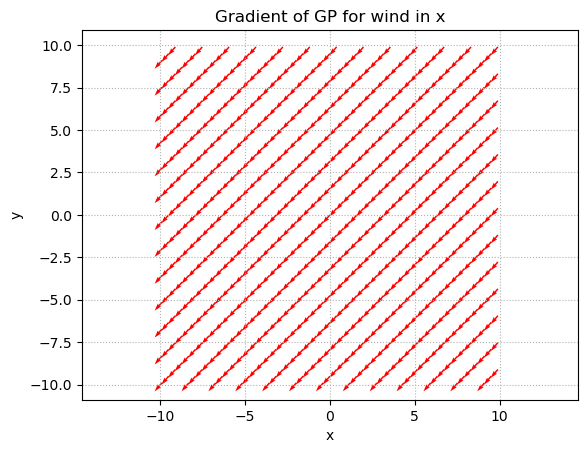

In [9]:
plot_wind_field(X=X_grid, y=y_grad, res=4, title="Gradient of GP for wind in x")

# Put together the prediction model

# 0.0) Nominal model

In [128]:
# Continuous time 
g = 9.81
tau = 0.075
k = 0.963
A = np.zeros([9,9])
A[0,3] = 1
A[1,4] = 1
A[2,5] = 1
A[3,7] = g
A[4,6] = -g
A[6,6] = -1/tau
A[7,7] = -1/tau
B = np.zeros([9,4])
B[5,3] = 1
B[6,0] = k/tau
B[7,1] = k/tau
B[8,2] = 1
Bd = np.zeros([9,2])
Bd[3,0] = 1
Bd[4,1] = 1

# Discrete time


In [129]:
from scipy.signal import cont2discrete, lti, dlti, dstep

C = np.identity(9)
D = np.zeros([9,4])
dt = 0.05
d_system = cont2discrete((A, B, C, D), dt, method='zoh')
A_d = d_system[0]
B_d = d_system[1]
C_d = d_system[2]
D_d = d_system[3]
with np.printoptions(precision=4, suppress=True):
    print(B_d)

[[ 0.      0.0022  0.      0.    ]
 [-0.0022  0.      0.      0.    ]
 [ 0.      0.      0.      0.0012]
 [ 0.      0.1276  0.      0.    ]
 [-0.1276  0.      0.      0.    ]
 [ 0.      0.      0.      0.05  ]
 [ 0.4686  0.      0.      0.    ]
 [ 0.      0.4686  0.      0.    ]
 [ 0.      0.      0.05    0.    ]]


In [130]:
#Also discretize the disturbance 
A_ = A
B_ = np.hstack([B, Bd])
C = np.identity(9)
D = np.zeros([9,4])
dt = 0.05
d_system = cont2discrete((A_, Bd, C, D), dt, method='zoh')
B_d_disc = d_system[1]
print(B_d_disc)

[[0.00125 0.     ]
 [0.      0.00125]
 [0.      0.     ]
 [0.05    0.     ]
 [0.      0.05   ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]]


# 0.1) Load the trained GP models

In [8]:
data = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_4.npz')
data_X = data['X']
data_y = data['y']
inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0]/30), :])

In [9]:
model = GPModel(inducing_points=inducing_points)
state_dict = torch.load('gpytorch_y1_model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
length_scale = (state_dict['covar_module.base_kernel.raw_lengthscale'].detach().numpy()[0])

In [11]:
model1 = GPModel(inducing_points=inducing_points)
state_dict = torch.load('gpytorch_y1_model.pth')
model1.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
model2 = GPModel(inducing_points=inducing_points)
state_dict = torch.load('gpytorch_y2_model.pth')
model2.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
# TODO: turn this into one function and move to ROS 

# 1) Retrieve mean prediction, standard deviation and gradient

In [14]:
def GP_predict(X):
    print(X)
    X_grad = torch.autograd.Variable(torch.Tensor(X), requires_grad = True)
    print(X_grad)
    observed_pred1 = (model1(X_grad))
    print(observed_pred1)
    mean1 = observed_pred1.mean.detach().numpy()
    covar1 = observed_pred1.covariance_matrix.detach().numpy()
    upper, lower = observed_pred1.confidence_region()
    print("up:", upper, lower)
    dydtest_x_ag = torch.autograd.grad(observed_pred1.mean.sum(), X_grad)[0]
    y_grad1 = dydtest_x_ag.detach().numpy()
    observed_pred2 = (model2(X_grad))
    mean2 = observed_pred2.mean.detach().numpy()
    covar2 = observed_pred2.covariance_matrix.detach().numpy()
    dydtest_x_ag = torch.autograd.grad(observed_pred2.mean.sum(), X_grad)[0]
    y_grad2 = dydtest_x_ag.detach().numpy()
    y_mean = np.vstack((mean1, mean2))
    y_covar = np.diag([covar1[0,0], covar2[0,0]])
    y_grad = np.zeros([2,9])
    y_grad[:,0] = y_grad1
    y_grad[:,1] = y_grad2
    print(y_grad1, y_grad2)
    return y_mean, y_covar, y_grad
    #plot_wind_field(X=X_grid[1300:1301], y=np.transpose(y), res=1)

In [15]:
# Multiple points versus one point 
y_pred, y_covar, y_grad = GP_predict(X_grid[1400:1401])
print("pred:", y_pred, y_covar, y_grad)

[[-0.792  0.792]]
tensor([[-0.7920,  0.7920]], requires_grad=True)
MultivariateNormal(loc: tensor([2.3183], grad_fn=<AddBackward0>))
up: tensor([2.1467], grad_fn=<SubBackward0>) tensor([2.4900], grad_fn=<AddBackward0>)
[[-0.07022712 -0.794266  ]] [[-2.9983745e-05 -3.1643660e-05]]
pred: [[2.3183348e+00]
 [2.6752221e-04]] [[0.00736389 0.        ]
 [0.         0.00077573]] [[-7.02271163e-02 -2.99837448e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.94265985e-01 -3.16436599e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


/home/johanna/.local/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2115.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


# 2) Initialize state and uncertainty

In [21]:
# Initialize state and uncertainty (uncertainty at the first state is zero)
x0 = np.zeros([9,1])
sigma_x0 = np.zeros([9,9])
u = np.zeros([4,1])

In [22]:
continuous_model(x0, sigma_x0, u)

NameError: name 'continuous_model' is not defined

# 3) Model prediction

In [23]:
def continuous_model(x_mean, x_covar, u):
    # Retrieve disturbance information 
    x_gp = np.transpose(x_mean[0:2,:])
    print(x_gp)
    d_mean, d_covar, d_grad = GP_predict(x_gp)
    print(d_covar)
    # Compute the mean of the next state
    x_full = np.vstack([x_mean, d_mean])
    print(x_full)
    x_i_next = np.matmul(np.hstack([A,Bd]), x_full) + np.matmul(B,u)
    # Compute the covariance of the next state 
    sigma_i_x = x_covar
    print(sigma_i_x)
    sigma_i_xd = np.matmul(d_grad, sigma_i_x)
    print(sigma_i_xd)
    sigma_i = np.bmat([[sigma_i_x, np.transpose(sigma_i_xd)], [sigma_i_xd, d_covar]])
    print(sigma_i)
    sigma_x_i_next = np.hstack([A,Bd]).dot(sigma_i).dot(np.transpose(np.hstack([A,Bd])))
    print(sigma_x_i_next)
    return(x_i_next, sigma_x_i_next)

In [24]:
x = [0,0]
x_ = x[0]
y_ = x[1]
x_gp = [[x_, y_]]
GP_predict(x_gp)

[[0, 0]]
tensor([[0., 0.]], requires_grad=True)
MultivariateNormal(loc: tensor([2.6278], grad_fn=<AddBackward0>))
[[-0.18441252 -0.21346347]] [[-2.0166817e-05 -1.8929026e-05]]


(array([[2.6277766e+00],
        [2.6719601e-04]], dtype=float32),
 array([[0.00787446, 0.        ],
        [0.        , 0.00069567]], dtype=float32),
 array([[-1.84412524e-01, -2.01668172e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.13463470e-01, -1.89290258e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

In [25]:
def discrete_model(x_mean, x_covar, u):
    # Retrieve disturbance information 
    x_gp = np.transpose(x_mean[0:2,:])
    d_mean, d_covar, d_grad = GP_predict(x_gp)
    # Compute the mean of the next state
    x_full = np.vstack([x_mean, d_mean])
    x_i_next = np.matmul(np.hstack([A_d,B_d_disc]), x_full) + np.matmul(B_d,u)
    # Compute the covariance of the next state 
    sigma_i_x = x_covar
    sigma_i_xd = np.matmul(d_grad, sigma_i_x)
    sigma_i = np.bmat([[sigma_i_x, np.transpose(sigma_i_xd)], [sigma_i_xd, d_covar]])
    stack_mat = np.hstack([A_d,B_d_disc])
    prod1 = np.hstack([A_d,B_d_disc]).dot(sigma_i)
    sigma_x_i_next = np.hstack([A_d,B_d_disc]).dot(sigma_i).dot(np.transpose(np.hstack([A_d,B_d_disc])))
    return x_i_next, sigma_x_i_next# , stack_mat, prod1)

In [26]:
x0 = np.ones([9,1])
sigma_x0 = np.zeros([9,9])
u = np.ones([4,1])
for i in range(10): 
    x0,sigma_x0 = discrete_model(x0, sigma_x0, u)
    print("x0:",x0, "sigma_x0:", sigma_x0)

[[1. 1.]]
tensor([[1., 1.]], requires_grad=True)
MultivariateNormal(loc: tensor([1.9821], grad_fn=<AddBackward0>))
[[-0.13324355 -0.6443485 ]] [[-2.2584731e-05 -4.6333655e-05]]
x0: [[1.06465405]
 [1.0378238 ]
 [1.05125   ]
 [1.58470081]
 [0.51441312]
 [1.05      ]
 [0.98199643]
 [0.98199643]
 [1.05      ]] sigma_x0: [[1.69621315e-08 0.00000000e+00 0.00000000e+00 6.78485259e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.06224325e-09 0.00000000e+00 0.00000000e+00
  4.24897298e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.78485259e-07 0.00000000e+00 0.00000000e+00 2.71394104e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.24897298e-08 0.00000000e+00 0.00000000e+00
  1.69958919e-06 0.00000000e+00 0.00000000e+00 0.000

In [148]:
x_i_next[:,0]

NameError: name 'x_i_next' is not defined

In [149]:
data = np.load('/home/johanna/MasterThesis/data/wind_data_1.npz')
data_X = data['X']
data_y = data['y']
data_vel = data['velocity_pred']

KeyError: 'velocity_pred is not a file in the archive'

In [150]:
data.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fe8e4f15250>)

In [13]:
import casadi

In [29]:
# Casadi stuff 

x0 = casadi.SX.sym("x_0")
x1 = casadi.SX.sym("x_1")

In [30]:
X = np.array([x0, x1])
casadi.DM(x0.detach().numpy())

Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.

In [ ]:
X_grad = torch.autograd.Variable(torch.Tensor(X), requires_grad = True)

In [27]:
def GP_predict(X):
    print(X)
    X_grad = torch.autograd.Variable(torch.Tensor(X), requires_grad = True)
    print(X_grad)
    observed_pred1 = (model1(X_grad))
    mean1 = observed_pred1.mean.detach().numpy()
    covar1 = observed_pred1.covariance_matrix.detach().numpy()
    dydtest_x_ag = torch.autograd.grad(observed_pred1.mean.sum(), X_grad)[0]
    y_grad1 = dydtest_x_ag.detach().numpy()
    observed_pred2 = (model2(X_grad))
    mean2 = observed_pred2.mean.detach().numpy()
    covar2 = observed_pred2.covariance_matrix.detach().numpy()
    dydtest_x_ag = torch.autograd.grad(observed_pred2.mean.sum(), X_grad)[0]
    y_grad2 = dydtest_x_ag.detach().numpy()
    y_mean = np.vstack((mean1, mean2))
    y_covar = np.diag([covar1[0,0], covar2[0,0]])
    y_grad = np.zeros([2,9])
    y_grad[:,0] = y_grad1
    y_grad[:,1] = y_grad2
    return y_mean, y_covar, y_grad
    #plot_wind_field(X=X_grid[1300:1301], y=np.transpose(y), res=1)

In [32]:
from casadi import * 

In [33]:
class GPR(Callback):
    def __init__(self, name, opts: dict = None):
        if opts is None:
            opts = dict()

        Callback.__init__(self)
        self.construct(name, opts)
        
    def eval(self, arg):
        X_grad = torch.autograd.Variable(np.array([arg[0], arg[1]]), requires_grad = True)
        observed_pred1 = (model1(X_grad))
        mean1 = observed_pred1.mean.detach().numpy()
        covar1 = observed_pred1.covariance_matrix.detach().numpy()
        dydtest_x_ag = torch.autograd.grad(observed_pred1.mean.sum(), X_grad)[0]
        y_grad1 = dydtest_x_ag.detach().numpy()
        observed_pred2 = (model2(X_grad))
        mean2 = observed_pred2.mean.detach().numpy()
        covar2 = observed_pred2.covariance_matrix.detach().numpy()
        dydtest_x_ag = torch.autograd.grad(observed_pred2.mean.sum(), X_grad)[0]
        y_grad2 = dydtest_x_ag.detach().numpy()
        y_mean = np.vstack((mean1, mean2))
        y_covar = np.diag([covar1[0,0], covar2[0,0]])
        y_grad = np.zeros([2,9])
        y_grad[:,0] = y_grad1
        y_grad[:,1] = y_grad2
        return y_mean

In [34]:
gpr = GPR('GPR')
print(gpr)

GPR:(i0)->(o0) CallbackInternal


In [35]:
w = casadi.SX.sym('w', 2)
DM(w)

DM([nan, nan])

In [36]:
prob = {'f': gpr(w), 'x': w, }
print(prob)

RuntimeError: .../casadi/core/function_internal.cpp:1821: 'eval_sx' not defined for CallbackInternal

In [37]:
from casadi import *
import tensorflow as tf
import gpflow

# Needs: pip install gpflow casadi

# Create data points: a noisy sine wave
N = 20
np.random.seed(0)
data = np.linspace(0, 10, N).reshape((N, 1))
value = np.sin(data) + np.random.normal(0, 0.1, (N, 1))

# Perform Gaussian process regression
model = gpflow.models.GPR((data, value), gpflow.kernels.Constant(1) + gpflow.kernels.Linear(1) + gpflow.kernels.White(
    1) + gpflow.kernels.RBF(1))
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))


# Package the resulting regression model in a CasADi callback
class GPR(Callback):
    def __init__(self, name, opts: dict = None):
        if opts is None:
            opts = dict()

        Callback.__init__(self)
        self.construct(name, opts)

    def eval(self, arg):
        [mean, _] = model.predict_f(np.array(arg[0]))
        return [mean]


# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', opts={"enable_fd": True})
print(gpr)

# Find the minimum of the regression model
x = MX.sym("x")
solver = nlpsol("solver", "ipopt", {"x": x, "f": gpr(x)})
res = solver(x0=5)

plot(res["x"], gpr(res["x"]), 'k*', markersize=10, label="Function minimum by CasADi/Ipopt")
legend()
savefig('gpflow1d_min.png', bbox_inches='tight')

ModuleNotFoundError: No module named 'tensorflow'

# Sparse GP hard code

In [12]:
model = GPModel(inducing_points=inducing_points)
state_dict = torch.load('gpytorch_y1_model.pth')
model.load_state_dict(state_dict)
print(state_dict)

constraint = model.covar_module.raw_outputscale_constraint
length_scale = constraint.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
output_scale = constraint.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
u = state_dict['variational_strategy.inducing_points'].detach().numpy()
mu = np.array([state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
S = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

OrderedDict([('variational_strategy.inducing_points', tensor([[  0.5466,   1.7361],
        [  2.4568,  -1.6995],
        [  8.4464,  -0.1550],
        [  7.5685,   6.7030],
        [  2.1948,   9.1642],
        [ -6.4874,   9.3269],
        [ -5.8486,   1.4142],
        [ -4.8806,  -1.7437],
        [ -4.4582,  -3.1693],
        [ -8.9308,  -8.3369],
        [ -6.1267, -10.0193],
        [ -0.5081,  -9.9597],
        [  4.3458,  -9.4745],
        [  8.5289,  -9.7466],
        [  3.6850,  -5.1995],
        [ -1.6747,  -0.4793],
        [ -9.0577,  -1.8116],
        [ -9.8771,   0.3585],
        [ -9.4140,   3.3788],
        [ -8.9893,   6.6042],
        [ -2.2273,   5.3325],
        [  8.4296,   9.5419],
        [  9.6030,   3.6327],
        [  9.2675,  -3.2922],
        [  9.6410,  -5.7559],
        [  5.6534,   2.4615],
        [  2.1282,   4.6597],
        [ -8.5189,  -2.8356],
        [ -5.7213,  -4.1700],
        [ -1.8382,  -6.6605],
        [  5.9350,  -2.2478]])), ('variational

In [13]:
x1 = torch.Tensor([[0, 0]])
observed_pred = (model(x1))
observed_pred.mean.detach().numpy()

array([2.6277766], dtype=float32)

In [14]:
from scipy.spatial.distance import pdist, cdist, squareform
import casadi as cs

In [15]:
class GPpredict_():
    def __init__(self, l, sigma_f, u, mu, S):
        self.l=l
        self.sigma_f=sigma_f
        self.u=u
        self.mu=mu
        self.S=S
        self.Kuu = self.squared_exponential_kernel(u, u) + 1e-03* np.identity(self.u.shape[-2])
        self.inv_L = np.linalg.inv(np.linalg.cholesky(self.Kuu))
        self.var = np.matmul(S, np.transpose(S)) - np.identity(S.shape[-1])
    def squared_exponential_kernel(self, x_1, x_2=None):
        """
        Anisotropic (diagonal length-scale) matrix squared exponential kernel. Computes a covariance matrix from points
        in x_1 and x_2.

        Args:
            x_1: Array of m points (m x d).
            x_2: Array of n points (n x d).

        Returns:
            Covariance matrix (m x n).
        """

        if isinstance(x_2, cs.SX):
            return self._squared_exponential_kernel_cs(x_1, x_2)

        # Length scale parameter
        len_scale = self.l

        # Vertical variation parameter
        sigma_f = self.sigma_f

        x_1 = np.atleast_2d(x_1)
        length_scale = self._check_length_scale(x_1, len_scale)
        if x_2 is None:
            dists = pdist(x_1 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)
            # convert from upper-triangular matrix to square matrix
            k = squareform(k)
            np.fill_diagonal(k, 1)
        else:
            dists = cdist(x_1 / length_scale, x_2 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)

        return k
    
    def _check_length_scale(self, x, length_scale):
        length_scale = np.squeeze(length_scale).astype(float)
        if np.ndim(length_scale) > 1:
            raise ValueError("length_scale cannot be of dimension greater than 1")
        if np.ndim(length_scale) == 1 and x.shape[1] != length_scale.shape[0]:
            raise ValueError("Anisotropic kernel must have the same number of dimensions as data (%d!=%d)"
                             % (length_scale.shape[0], x.shape[1]))
        return length_scale

    def _squared_exponential_kernel_cs(self, x_1, x_2):
        """
        Symbolic implementation of the anisotropic squared exponential kernel
        :param x_1: Array of m points (m x d).
        :param x_2: Array of n points (m x d).
        :return: Covariance matrix (m x n).
        """

        # Length scale parameter
        len_scale = self.l
        # Vertical variation parameter
        sigma_f =  self.sigma_f

        if x_1.shape != x_2.shape and x_2.shape[0] == 1:
            tiling_ones = cs.SX.ones(x_1.shape[0], 1)
            d = x_1 - cs.mtimes(tiling_ones, x_2)
            dist = cs.sum2(d ** 2 / cs.mtimes(tiling_ones, cs.SX(len_scale ** 2).T))
        else:
            d = x_1 - x_2
            dist = cs.sum1(d ** 2 / cs.SX(len_scale ** 2).T)

        return sigma_f * cs.SX.exp(-.5 * dist)
    def predict(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04* np.identity(X.shape[-2])
        interp_term = cs.mtimes(self.inv_L, Kxu)
        mean = cs.mtimes(self.mu, interp_term)
        covar = Kxx + cs.mtimes(interp_term.T,cs.mtimes(self.var, interp_term))
        return mean, covar
    def mean(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        interp_term = cs.mtimes(self.inv_L, Kxu)
        mean = cs.mtimes(self.mu, interp_term)
        return mean
    def covar(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04* np.identity(X.shape[-2])
        interp_term = cs.mtimes(self.inv_L, Kxu)
        covar = Kxx + cs.mtimes(interp_term.T,cs.mtimes(self.var, interp_term))
        return mean

In [16]:
x1 = cs.SX.sym('x_5', 1)
x2 = cs.SX.sym('x_6', 1)
print(x1,x2)
X = cs.horzcat(x1,x2)
print(X)

x_5 x_6
[[x_5, x_6]]


In [17]:
def f(x1, x2):
    X = cs.horzcat(x1,x2)
    mean= predict.mean(X)
    return mean

In [18]:
X = np.array([[-11,0]])

In [19]:
f1 = cs.Function('f',[x1,x2],[f(x1,x2)]);
f1(-16,0)

NameError: name 'predict' is not defined

In [267]:
predict = GPpredict_(length_scale, output_scale, u, mu, S)
mean= predict.mean(X)
print(mean)

1.43648


In [268]:
from casadi import *

In [277]:
#Load the trained GP model
#Load the data
data = np.load('/home/johanna/MasterThesis/data/backup_structured_x_wind/wind_data_4.npz')
data_X = data['X']
data_y = data['y']
inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0]/30), :])

#Load model in first direction
model1 = GPModel(inducing_points=inducing_points)
state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y1_model.pth')
model1.load_state_dict(state_dict)
constraint1 = model1.covar_module.raw_outputscale_constraint
length_scale1 = constraint1.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
output_scale1 = constraint1.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
u1 = state_dict['variational_strategy.inducing_points'].detach().numpy()
mu1 = np.array([state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
S1 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

prediction_model1 = GPpredict_(length_scale1, output_scale1, u1, mu1, S1)

model2 = GPModel(inducing_points=inducing_points)
state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y2_model.pth')
model2.load_state_dict(state_dict)
constraint2 = model2.covar_module.raw_outputscale_constraint
length_scale2 = constraint2.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
output_scale2 = constraint2.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
u2 = state_dict['variational_strategy.inducing_points'].detach().numpy()
mu2 = np.array(
    [state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
S2 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

prediction_model2 = GPpredict_(length_scale2, output_scale2, u2, mu2, S2)

In [278]:
def f(x1, x2):
    X = cs.horzcat(x1,x2)
    mean1= prediction_model1.mean(X)
    return mean1
f1 = cs.Function('f',[x1,x2],[f(x1,x2)]);
f1(0,0)

DM(2.59815)

In [281]:
model1(torch.FloatTensor([[0,0]])).mean.detach().numpy()

array([2.2750657], dtype=float32)

In [132]:
class GPpredict_():
    def __init__(self, l, sigma_f, u, mu, S):
        self.l = l
        self.sigma_f = sigma_f
        self.u = u
        self.mu = mu
        self.S = S
        self.Kuu = self.squared_exponential_kernel(u, u) + 1e-03 * np.identity(self.u.shape[-2])
        self.inv_L = np.linalg.inv(np.linalg.cholesky(self.Kuu))
        self.var = np.matmul(S, np.transpose(S)) - np.identity(S.shape[-1])

    def squared_exponential_kernel(self, x_1, x_2=None):
        """
        Anisotropic (diagonal length-scale) matrix squared exponential kernel. Computes a covariance matrix from points
        in x_1 and x_2.

        Args:
            x_1: Array of m points (m x d).
            x_2: Array of n points (n x d).

        Returns:
            Covariance matrix (m x n).
        """

        if isinstance(x_2, casadi.SX):
            return self._squared_exponential_kernel_cs(x_1, x_2)

        # Length scale parameter
        len_scale = self.l

        # Vertical variation parameter
        sigma_f = self.sigma_f

        x_1 = np.atleast_2d(x_1)
        length_scale = self._check_length_scale(x_1, len_scale)
        if x_2 is None:
            dists = pdist(x_1 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)
            # convert from upper-triangular matrix to square matrix
            k = squareform(k)
            np.fill_diagonal(k, 1)
        else:
            dists = cdist(x_1 / length_scale, x_2 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)

        return k

    def _check_length_scale(self, x, length_scale):
        length_scale = np.squeeze(length_scale).astype(float)
        if np.ndim(length_scale) > 1:
            raise ValueError("length_scale cannot be of dimension greater than 1")
        if np.ndim(length_scale) == 1 and x.shape[1] != length_scale.shape[0]:
            raise ValueError("Anisotropic kernel must have the same number of dimensions as data (%d!=%d)"
                             % (length_scale.shape[0], x.shape[1]))
        return length_scale

    def _squared_exponential_kernel_cs(self, x_1, x_2):
        """
        Symbolic implementation of the anisotropic squared exponential kernel
        :param x_1: Array of m points (m x d).
        :param x_2: Array of n points (m x d).
        :return: Covariance matrix (m x n).
        """

        # Length scale parameter
        len_scale = self.l
        # Vertical variation parameter
        sigma_f = self.sigma_f

        if x_1.shape != x_2.shape and x_2.shape[0] == 1:
            tiling_ones = casadi.SX.ones(x_1.shape[0], 1)
            d = x_1 - casadi.mtimes(tiling_ones, x_2)
            dist = casadi.sum2(d ** 2 / casadi.mtimes(tiling_ones, casadi.SX(len_scale ** 2).T))
        else:
            d = x_1 - x_2
            dist = casadi.sum1(d ** 2 / casadi.SX(len_scale ** 2).T)

        return sigma_f * casadi.SX.exp(-.5 * dist)

    def predict(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04 * np.identity(X.shape[-2])
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        mean = casadi.mtimes(self.mu, interp_term)
        covar = Kxx + casadi.mtimes(interp_term.T, casadi.mtimes(self.var, interp_term))
        return mean, covar

    def mean(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        test = casadi.mtimes(self.mu, self.inv_L)
        print(test.shape)
        mean = casadi.mtimes(self.mu, interp_term)
        return mean

    def covar(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04 * np.identity(X.shape[-2])
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        print(interp_term.shape)
        covar = Kxx + casadi.mtimes(interp_term.T, casadi.mtimes(self.var, interp_term))
        return covar

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
def _matern_kernel_cs(x_1, x_2, length_scale):
        """
        Symbolic implementation of the anisotropic squared exponential kernel
        :param x_1: Array of m points (m x d).
        :param x_2: Array of n points (m x d).
        :return: Covariance matrix (m x n).
        """

        # Length scale parameter
        len_scale = length_scale

        d = (abs(x_1[0]-x_2[0]))/len_scale[0] **2+ (abs(x_1[1]-x_2[1]))/len_scale[1] # TODO: check if squared or not
        print(d) 
        k = 1 + sqrt(5) * d + 5/3 * d ** 2 + casadi.SX.exp(- sqrt(5) * d)

        return k

In [20]:
def cov_matrix(x1, x2, cov_function, length_scale, output_scale) -> np.array:
    return np.array([[cov_function(a, b, length_scale, output_scale) for a in x1] for b in x2])

In [369]:
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [89]:
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
covar_module.outputscale = output_scale
covar_module.base_kernel.lengthscale = torch.Tensor(length_scale)

In [370]:
x1 = torch.randn(10, 2)
x2 = torch.randn(10, 2)
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2))
covar = covar_module(x1,x2)  # Output: LazyVariable of size (10 x 10)
print(covar.detach().numpy())

[[2.33055912e-02 2.08357006e-01 4.43746150e-02 5.62368147e-03
  2.39281014e-01 2.71179438e-01 4.87431675e-01 6.59181893e-01
  4.86321412e-02 2.86762923e-01]
 [1.60200074e-02 9.05320805e-04 2.14634649e-02 1.60669163e-02
  8.49599659e-04 1.23536796e-03 7.37863884e-04 4.27832507e-04
  2.00892910e-02 1.47261890e-04]
 [1.16611786e-01 2.01199815e-01 3.26504976e-01 3.97158824e-02
  2.16114700e-01 3.98408860e-01 3.47797453e-01 2.90645540e-01
  3.50367129e-01 1.07362427e-01]
 [1.91233680e-01 5.90712018e-02 6.15330637e-01 9.88800302e-02
  5.94249405e-02 1.09675847e-01 7.11840019e-02 4.90280092e-02
  6.19557202e-01 1.80834476e-02]
 [3.43802082e-03 3.90245090e-03 7.52145946e-02 2.49917284e-01
  4.42508003e-03 1.08670682e-01 1.23194708e-02 1.70405824e-02
  7.09801465e-02 4.88254838e-02]
 [7.22265523e-03 4.73513119e-02 7.76290544e-04 3.13388009e-05
  4.36096936e-02 1.50620076e-03 1.71983484e-02 1.06113255e-02
  8.86396912e-04 1.20136410e-03]
 [4.41306174e-01 1.80603996e-01 4.01793607e-02 2.09435821e

# Check Dynamics Model

In [16]:
from casadi import *
import torch
from scipy.spatial.distance import pdist, cdist, squareform
import casadi as cs
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from scipy.signal import cont2discrete

In [17]:
class DynamicModel:

    def __init__(self, system):
        self.nvar = self.nu + self.nx
        self.system = system

    def __str__(self):
        result = 'Dynamical Model: ' + str(type(self)) + '\n' +\
               'System: ' + str(self.system) + '\n'

        if hasattr(self, 'interfaces'):
            result += 'Interfaces: '

            for interface in self.interfaces:
                result += interface + " "

            result += "\n"

        result += 'States: ' + str(self.states) + '\n'
        result += 'Inputs: ' + str(self.inputs) + '\n'
        return result

    # Appends upper bounds from system
    def upper_bound(self):
        result = np.array([])

        for input in self.inputs:
            result = np.append(result, self.system.upper_bound[input])

        for state in self.states:
            result = np.append(result, self.system.upper_bound[state])

        return result

    # Appends lower bounds from system
    def lower_bound(self):
        result = np.array([])

        for input in self.inputs:
            result = np.append(result, self.system.lower_bound[input])

        for state in self.states:
            result = np.append(result, self.system.lower_bound[state])

        return result


In [18]:
class DroneModel(DynamicModel):

    def __init__(self, system, options):
        # Check whether model should be nonlinear and whether yaw component should be included or not
        self.nonlin = options['nonlin']
        self.with_yaw = options['with_yaw']

        if not self.with_yaw:
            self.states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'v', 'spline']
            self.states_from_sensor = [True, True, True, True, True, True, True, True, True, False]
            self.states_from_sensor_at_infeasible = [True, True, True, True, True, True, True, True, True, False]

            self.inputs = ['phi_c', 'theta_c', 'thrust_c', 'a']
            self.possible_inputs_to_vehicle = ['phi_c', 'theta_c', 'thrust_c', 'a']
        else:
            self.states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'v', 'spline']
            self.states_from_sensor = [True, True, True, True, True, True, True, True, True, True, False]
            self.states_from_sensor_at_infeasible = [True, True, True, True, True, True, True, True, True, True, False]

            self.inputs = ['phi_c', 'theta_c', 'dpsi_c', 'thrust_c', 'a']
            self.possible_inputs_to_vehicle = ['phi_c', 'theta_c', 'dpsi_c', 'thrust_c', 'a']

        # Load the trained GP model
        # Load the data
        data = np.load('/home/johanna/MasterThesis/data/wind_data_4.npz')
        data_X = data['X']
        data_y = data['y']
        inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0] / 30), :])

        # Load model in first direction
        self.model1 = GPModel(inducing_points=inducing_points)
        state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y1_model.pth')
        self.model1.load_state_dict(state_dict)
        constraint1 = self.model1.covar_module.raw_outputscale_constraint
        length_scale1 = constraint1.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
        output_scale1 = constraint1.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
        u1 = state_dict['variational_strategy.inducing_points'].detach().numpy()
        mu1 = np.array(
            [state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
        S1 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

        self.prediction_model1 = GPpredict_(length_scale1, output_scale1, u1, mu1, S1)

        self.model2 = GPModel(inducing_points=inducing_points)
        state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y2_model.pth')
        self.model2.load_state_dict(state_dict)
        constraint2 = self.model2.covar_module.raw_outputscale_constraint
        length_scale2 = constraint2.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
        output_scale2 = constraint2.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
        u2 = state_dict['variational_strategy.inducing_points'].detach().numpy()
        mu2 = np.array(
            [state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
        S2 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

        self.prediction_model2 = GPpredict_(length_scale2, output_scale2, u2, mu2, S2)

        self.nu = len(self.inputs)
        self.nx = len(self.states)
        super(DroneModel, self).__init__(system)

    def continuous_model(self, x, u):

        # Input to the GP
        x_gp = casadi.horzcat(x[0], x[1])

        # States
        vx = x[3]
        vy = x[4]
        vz = x[5]
        phi = x[6]
        theta = x[7]
        if not self.with_yaw:
            v = x[8]
            spline = x[9]
        else:
            psi = x[8]
            v = x[9]
            spline = x[10]

        # Inputs
        phi_c = u[0]            # Commanded roll angle around body frame x-axis [rad]
        theta_c = u[1]          # Commanded pitch angle around body frame y-axis [rad]
        if not self.with_yaw:
            thrust_c = u[2]     # Commanded acceleration along body frame z-axis [m/s^2]
            a = u[3]
        else:
            dpsi_c = u[2]       # Commanded yaw rate around body frame z-axis [rad/s]
            thrust_c = u[3]     # Commanded acceleration along body frame z-axis [m/s^2]
            a = u[4]
        # Note: thrust_c = desired thrust (N) / mass (kg)
        # The final commanded thrust to PX4 is T_c in [0, 1]
        # Find out relation between thrust_c and T_c by:
        # - Hovering experiments with different mass: (m+delta_m)*g = T_c' = m*(g+thrust_c)
        # - Measuring PWM-thrust relation with force sensor: [0, 1] maps linearly to PWM values
        # Note also: a is a virtual control input, also called progress acceleration, allowing to limit the reference
        # velocity along the path when v is not included in the standard system states, and therefore included as an
        # extra state v

        # Identified constants
        k_phi = 1.04
        tau_phi = 0.17
        k_theta = 1.04
        tau_theta = 0.17
        # kD_x = 0.02  # TODO: minimum value from ETH paper
        # kD_y = 0.02  # TODO: minimum value from ETH paper

        # Constants
        m = 1.9
        g = 9.81

        # Calculate derivatives
        dx = vx
        dy = vy
        dz = vz

        if not self.nonlin:
            dvx = g * theta
            dvy = -g * phi
            # dvx = -kD_x * vx + g * theta
            # dvy = -kD_y * vy - g * phi
            dvz = thrust_c - g
        else:
            dvx = thrust_c * (casadi.sin(phi) * casadi.sin(psi) + casadi.cos(phi) * casadi.sin(theta) * casadi.cos(psi)) + self.prediction_model1.mean(x_gp)
            dvy = thrust_c * (-casadi.sin(phi) * casadi.cos(psi) + casadi.cos(phi) * casadi.sin(theta) * casadi.sin(psi)) + self.prediction_model2.mean(x_gp)
            dvz = thrust_c * (casadi.cos(phi) * casadi.cos(theta)) - g
        dphi = (k_phi * phi_c - phi) / tau_phi
        dtheta = (k_theta * theta_c - theta) / tau_theta
        if self.with_yaw:
            ddpsi = dpsi_c
        # dspline = vy  # TODO Change this value to something else
        # v = casadi.norm_2(np.array([vx, vy]))
        # v = casadi.norm_2(np.array([vx, vy, vz]))
        # dspline = v
        # dspline = casadi.sqrt(2)*vx
        # dspline = settings.weights.velocity_reference
        dv = a
        dspline = v

        if not self.with_yaw:
            return np.array([dx, dy, dz, dvx, dvy, dvz, dphi, dtheta, dv, dspline])
        else:
            return np.array([dx, dy, dz, dvx, dvy, dvz, dphi, dtheta, ddpsi, dv, dspline])

In [57]:
# Linear Gaussian Process Model
class DroneGPModel(DynamicModel):

    def __init__(self, system, options):
        # Check whether model should be nonlinear and whether yaw component should be included or not
        self.nonlin = options['nonlin']
        self.with_yaw = options['with_yaw']

        if not self.with_yaw:
            self.states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'v', 'spline']
            self.states_from_sensor = [True, True, True, True, True, True, True, True, True, False]
            self.states_from_sensor_at_infeasible = [True, True, True, True, True, True, True, True, True, False]

            self.inputs = ['phi_c', 'theta_c', 'thrust_c', 'a']
            self.possible_inputs_to_vehicle = ['phi_c', 'theta_c', 'thrust_c', 'a']
        else:
            self.states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'v', 'spline']
            self.states_from_sensor = [True, True, True, True, True, True, True, True, True, True, False]
            self.states_from_sensor_at_infeasible = [True, True, True, True, True, True, True, True, True, True, False]

            self.inputs = ['phi_c', 'theta_c', 'dpsi_c', 'thrust_c', 'a']
            self.possible_inputs_to_vehicle = ['phi_c', 'theta_c', 'dpsi_c', 'thrust_c', 'a']

        # Constants
        self.g = 9.81

        # Identified constants
        self.tau_phi = 0.17
        self.k_phi = 1.04
        self.tau_theta = 0.17
        self.k_theta = 1.04
        self.kD = 0.02  # Drag coefficient

        # Initialize continuous matrices
        if not self.with_yaw:
            self.A = np.zeros([8,8])
            self.A[0,3] = 1
            self.A[1,4] = 1
            self.A[2,5] = 1
            self.A[3,7] = self.g
            self.A[4,6] = -self.g
            self.A[6,6] = -1/self.tau_phi
            self.A[7,7] = -1/self.tau_theta
            self.B = np.zeros([8,3])
            self.B[6,0] = self.k_theta/self.tau_theta
            self.B[7,1] = self.k_theta/self.tau_phi
            self.Bd = np.zeros([8,2])
            self.Bd[3,0] = 1
            self.Bd[4,1] = 1
        else:
            self.A = np.zeros([9,9])
            self.A[0,3] = 1
            self.A[1,4] = 1
            self.A[2,5] = 1
            self.A[3,7] = self.g
            self.A[4,6] = -self.g
            self.A[6,6] = -1/self.tau_phi
            self.A[7,7] = -1/self.tau_theta
            self.B = np.zeros([9,4])
            self.B[5,3] = 1
            self.B[6,0] = self.k_theta/self.tau_theta
            self.B[7,1] = self.k_theta/self.tau_phi
            self.B[8,2] = 1
            self.Bd = np.zeros([9,2])
            self.Bd[3,0] = 1
            self.Bd[4,1] = 1
            self.D = np.zeros([9,1])
            self.D[5, 0] = -self.g
            
        # Find the discrete matrices
        C = np.identity(9)
        D = np.zeros([9,4])
        dt = 0.05
        d_system = cont2discrete((self.A, self.Bd, C, D), dt, method='zoh')
        self.A_d = d_system[0]
        self.A_d = self.A_d[[0,1,3,4],:]
        self.A_d = self.A_d[:,[0,1,3,4]]
        
        print("Ad", self.A_d)
        
        self.Bd_d = d_system[1]
        self.Bd_d = self.Bd_d[[0,1,3,4],:]
        
        print("Bd", self.Bd_d)

        #Load the trained GP model
        #Load the data
        data = np.load('/home/johanna/MasterThesis/data/wind_data_4.npz')
        data_X = data['X']
        data_y = data['y']
        inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0]/30), :])

        #Load model in first direction
        self.model1 = GPModel(inducing_points=inducing_points)
        state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y1_model.pth')
        self.model1.load_state_dict(state_dict)
        constraint1 = self.model1.covar_module.raw_outputscale_constraint
        length_scale1 = constraint1.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
        output_scale1 = constraint1.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
        u1 = state_dict['variational_strategy.inducing_points'].detach().numpy()
        mu1 = np.array([state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
        S1 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

        self.prediction_model1 = GPpredict_(length_scale1, output_scale1, u1, mu1, S1)

        self.model2 = GPModel(inducing_points=inducing_points)
        state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y2_model.pth')
        self.model2.load_state_dict(state_dict)
        constraint2 = self.model2.covar_module.raw_outputscale_constraint
        length_scale2 = constraint2.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
        output_scale2 = constraint2.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
        u2 = state_dict['variational_strategy.inducing_points'].detach().numpy()
        mu2 = np.array(
            [state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
        S2 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

        self.prediction_model2 = GPpredict_(length_scale2, output_scale2, u2, mu2, S2)

        self.nu = len(self.inputs)
        self.nx = len(self.states)
        super(DroneGPModel, self).__init__(system)

    def continuous_model(self, x, u): #, param, settings):
        # Load runtime parameters
        #settings.weights.set_weights(param)

        # States
        if not self.with_yaw:
            v = x[8]
            spline = x[9]
            x_mean = x[:8]
            inp = u[:3]
        else:
            v = x[9]
            spline = x[10]
            x_mean = x[:9]
            inp = u[:4]

        x_gp = casadi.horzcat(x_mean[0], x_mean[1])
        mean1 = self.prediction_model1.mean(x_gp)
        mean2 = self.prediction_model2.mean(x_gp)
        d_mean = casadi.vertcat(mean1, mean2)
        # d_mean = [test(x_gp[0], x_gp[1]),  test(x_gp[0], x_gp[1])]
        # print(d_mean)

        # Compute the mean of the next state
        x_full = casadi.vertcat(x_mean, d_mean)
        x_i_next = casadi.mtimes(np.hstack([self.A,self.Bd]), x_full) + casadi.mtimes(self.B, inp) + self.D

        # Other inputs
        if not self.with_yaw:
            a = u[3]
        else:
            a = u[4]
        # Note: thrust_c = desired thrust (N) / mass (kg)
        # The final commanded thrust to PX4 is T_c in [0, 1]
        # Find out relation between thrust_c and T_c by:
        # - Hovering experiments with different mass: (m+delta_m)*g = T_c' = m*(g+thrust_c)
        # - Measuring PWM-thrust relation with force sensor: [0, 1] maps linearly to PWM values
        # Note also: a is a virtual control input, also called progress acceleration, allowing to limit the reference
        # velocity along the path when v is not included in the standard system states, and therefore included as an
        # extra state v


        # dspline = vy  # TODO Change this value to something else
        # v = casadi.norm_2(np.array([vx, vy]))
        # v = casadi.norm_2(np.array([vx, vy, vz]))
        # dspline = v
        # dspline = casadi.sqrt(2)*vx
        # dspline = settings.weights.velocity_reference
        dv = a
        dspline = v

        if not self.with_yaw:
            return np.array([x_i_next[0], x_i_next[1], x_i_next[2], x_i_next[3], x_i_next[4], x_i_next[5], x_i_next[6], x_i_next[7], dv, dspline])
        else:
            return np.array([x_i_next[0], x_i_next[1], x_i_next[2], x_i_next[3], x_i_next[4], x_i_next[5], x_i_next[6], x_i_next[7], x_i_next[8], dv, dspline])

    def uncertainty_prop_gp(self, x, u):

        # States
        if not self.with_yaw:
            sigma = x[10:]
        else:
            sigma = x[11:]
            
        sigma = .5 * sigma
            
        sigma_i_x = cs.reshape(sigma,4,4) #TODO: make this more efficient

        x_gp = casadi.horzcat(x[0], x[1])
        
         

        mean1, covar1, diff_gp1 = self.prediction_model1.predict(x_gp)
        mean2, covar2, diff_gp2 = self.prediction_model2.predict(x_gp)
#         print(covar1, covar2)
#         print("grad:",diff_gp1, diff_gp2)
        y_covar = cs.diag(cs.vertcat(covar1,covar2)) #np.eye(2) @ cs.vertcat(covar1,covar2) #np.array([[covar1, 0],[0,covar2]])
#         print(y_covar)
        y_grad = cs.SX.zeros(self.Bd_d.shape)
        y_grad[0,:] = diff_gp1
        y_grad[1,:] = diff_gp2
#         print("y_grad:", y_grad)
        sigma_i_xd = casadi.mtimes(sigma_i_x, y_grad)
#         print("sigma_i_xd",sigma_i_xd)
        sigma_i = cs.vertcat(cs.horzcat(sigma_i_x, sigma_i_xd), cs.horzcat(sigma_i_xd.T, y_covar + sigma_i_xd.T @ sigma_i_x @ sigma_i_xd))
#         print("sigma_i", sigma_i)
        sigma_x_i_next = casadi.mtimes(np.hstack([self.A_d,self.Bd_d]), casadi.mtimes(sigma_i,np.hstack([self.A_d,self.Bd_d]).T))
#         print("sigma_x_i_next", sigma_x_i_next)
        sigma_x_i_next = sigma_x_i_next
#         print("test:")
#         print("1)", self.A_d @ sigma_i_x @ self.A_d.T)
#         print("2)", self.A_d @ sigma_i_xd @ self.Bd_d.T)
#         print("3)", self.Bd_d @ y_covar @ self.Bd_d.T)
        
        return(cs.reshape(sigma_x_i_next, 16 ,1))
    

class GPpredict_():
    def __init__(self, l, sigma_f, u, mu, S):
        self.l = l
        self.sigma_f = sigma_f
        self.u = u
        self.mu = mu
        self.S = S
        self.Kuu = self.squared_exponential_kernel(u, u) + 1e-03 * np.identity(self.u.shape[-2])
        self.inv_L = np.linalg.inv(np.linalg.cholesky(self.Kuu))
        self.var = np.matmul(S, np.transpose(S)) - np.identity(S.shape[-1])
        self.alpha = np.matmul(self.mu, self.inv_L)
        self.alpha_diag = np.diag(self.alpha[0])

    def squared_exponential_kernel(self, x_1, x_2=None):
        """
        Anisotropic (diagonal length-scale) matrix squared exponential kernel. Computes a covariance matrix from points
        in x_1 and x_2.

        Args:
            x_1: Array of m points (m x d).
            x_2: Array of n points (n x d).

        Returns:
            Covariance matrix (m x n).
        """

        if isinstance(x_2, casadi.SX):
            return self._squared_exponential_kernel_cs(x_1, x_2)

        # Length scale parameter
        len_scale = self.l.T
        length_scale = np.array([[len_scale[0], len_scale[1]]])

        # Vertical variation parameter
        sigma_f = self.sigma_f

        #length_scale = self._check_length_scale(x_1, length_scale)
        if x_2 is None:
            dists = pdist(x_1 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)
            # convert from upper-triangular matrix to square matrix
            k = squareform(k)
            np.fill_diagonal(k, 1)
        else:
            dists = cdist(x_1 / length_scale , x_2 / length_scale, metric='sqeuclidean')
            k = sigma_f * np.exp(-.5 * dists)

        return k

    def _check_length_scale(self, x, length_scale):
        length_scale = np.squeeze(length_scale).astype(float)
        if np.ndim(length_scale) > 1:
            raise ValueError("length_scale cannot be of dimension greater than 1")
        if np.ndim(length_scale) == 1 and x.shape[1] != length_scale.shape[0]:
            raise ValueError("Anisotropic kernel must have the same number of dimensions as data (%d!=%d)"
                             % (length_scale.shape[0], x.shape[1]))
        return length_scale

    def _squared_exponential_kernel_cs(self, x_1, x_2):
        """
        Symbolic implementation of the anisotropic squared exponential kernel
        :param x_1: Array of m points (m x d).
        :param x_2: Array of n points (m x d).
        :return: Covariance matrix (m x n).
        """

        # Length scale parameter
        len_scale = self.l
        # Vertical variation parameter
        sigma_f = self.sigma_f
        
        if x_1.shape != x_2.shape and x_2.shape[0] == 1:
            tiling_ones = casadi.SX.ones(x_1.shape[0], 1)
            d = x_1 - casadi.mtimes(tiling_ones, x_2)
            dist = casadi.sum2(d ** 2 / casadi.mtimes(tiling_ones, casadi.SX(len_scale ** 2).T))
        else:
            d = x_1 - x_2
            dist = casadi.sum2(d ** 2 / casadi.SX(len_scale ** 2).T)

        return sigma_f * casadi.SX.exp(-.5 * dist)

    def diff(self, X):
        """
        Computes the symbolic differentiation of the kernel function, evaluated at point z and using the training
        dataset z_train. This function implements equation (80) from overleaf document, without the c^{v_x} vector,
        and for all the partial derivatives possible (m), instead of just one.

        :param z: evaluation point. Symbolic vector of length m
        :param z_train: training dataset. Symbolic matrix of shape n x m

        :return: an m x n matrix, which is the derivative of the exponential kernel function evaluated at point z
        against the training dataset.
        """
        
        # Length scale parameter
        len_scale = self.l
            
        # Get SE kernel first 
        kernel = self.squared_exponential_kernel(self.u, X)
        print("kernel", kernel)
        
        #Compute distance
        data_diff = self.u.T - cs.mtimes(X.T, cs.SX.ones(1, self.u.shape[0]))
        
        # Multiply distance with kernel
        kernel_tile = cs.mtimes(data_diff, kernel)
        
        # Divide by length scales
        L = np.diag([1/(len_scale[0] * 2), 1/(len_scale[1] * 2)])
        diff = cs.mtimes(L, kernel_tile)
        
        return diff
    
    def predict_diff(self, X):
        # Length scale parameter
        len_scale = self.l
            
        # Get SE kernel first 
        kernel = self.squared_exponential_kernel(self.u, X)
        
        # Multiply kernel with alpha
        kernel_tile = cs.mtimes(self.alpha_diag, kernel)
        
        #Compute distance
        data_diff = self.u.T - cs.mtimes(X.T, cs.SX.ones(1, self.u.shape[0]))
        
        # Divide by length scales 
        L = np.diag([1/(len_scale[0] ** 2), 1/(len_scale[1] ** 2)])
        
        diff = cs.mtimes(L, (cs.mtimes(data_diff, kernel_tile)))
        
        return diff 

    def predict(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04 * np.identity(X.shape[-2])
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        mean = casadi.mtimes(self.mu, interp_term)
        covar = Kxx + casadi.mtimes(interp_term.T, casadi.mtimes(self.var, interp_term))
        kernel_tile = cs.mtimes(self.alpha_diag, Kxu)
        data_diff = self.u.T - cs.mtimes(X.T, cs.SX.ones(1, self.u.shape[0]))
        L = np.diag([1 / (self.l[0] ** 2), 1 / (self.l[1] ** 2)])
        diff_gp = cs.mtimes(L, (cs.mtimes(data_diff, kernel_tile)))
        return mean, covar, diff_gp

    def mean(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        mean = casadi.mtimes(self.mu, interp_term)
        return mean

    def covar(self, X):
        Kxu = self.squared_exponential_kernel(self.u, X)
        
        Kxx = self.squared_exponential_kernel(X, X) + 1e-04 * np.identity(X.shape[-2])
        
        interp_term = casadi.mtimes(self.inv_L, Kxu)
        
        covar = Kxx + casadi.mtimes(interp_term.T, casadi.mtimes(self.var, interp_term))
        return covar

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [58]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
C = np.identity(2)
D = np.zeros([2,1])
dt = 0.01
d_system = cont2discrete((A, B, C, D), dt, method='zoh')
A_d = d_system[0]
B_d = d_system[1]

In [59]:
A_tilde = np.hstack([A_d, B_d])
sigma = np.array([[0,0,0],[0,0,0],[0,0,0.01]])
for i in range(101):
    sigma = A_tilde.dot(sigma).dot(A_tilde.T)
    sigma = np.array([[sigma[0,0], sigma[0,1], 0], [sigma[1,0], sigma[1,1], 0], [0,0,0.01]])
    print(sigma)

[[2.5e-11 5.0e-09 0.0e+00]
 [5.0e-09 1.0e-06 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-02]]
[[2.5e-10 2.0e-08 0.0e+00]
 [2.0e-08 2.0e-06 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-02]]
[[8.75e-10 4.50e-08 0.00e+00]
 [4.50e-08 3.00e-06 0.00e+00]
 [0.00e+00 0.00e+00 1.00e-02]]
[[2.1e-09 8.0e-08 0.0e+00]
 [8.0e-08 4.0e-06 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-02]]
[[4.125e-09 1.250e-07 0.000e+00]
 [1.250e-07 5.000e-06 0.000e+00]
 [0.000e+00 0.000e+00 1.000e-02]]
[[7.15e-09 1.80e-07 0.00e+00]
 [1.80e-07 6.00e-06 0.00e+00]
 [0.00e+00 0.00e+00 1.00e-02]]
[[1.1375e-08 2.4500e-07 0.0000e+00]
 [2.4500e-07 7.0000e-06 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e-02]]
[[1.7e-08 3.2e-07 0.0e+00]
 [3.2e-07 8.0e-06 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-02]]
[[2.4225e-08 4.0500e-07 0.0000e+00]
 [4.0500e-07 9.0000e-06 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e-02]]
[[3.325e-08 5.000e-07 0.000e+00]
 [5.000e-07 1.000e-05 0.000e+00]
 [0.000e+00 0.000e+00 1.000e-02]]
[[4.4275e-08 6.0500e-07 0.0000e+00]
 [6.0500e-07 1.1000e-05 0.0000e+00]


In [60]:
A_d
sigma = 0.01 * np.identity(2)
for i in range(21):
    sigma = A_d.dot(sigma).dot(A_d.T)
    print(sigma)

[[0.010001 0.0001  ]
 [0.0001   0.01    ]]
[[0.010004 0.0002  ]
 [0.0002   0.01    ]]
[[0.010009 0.0003  ]
 [0.0003   0.01    ]]
[[0.010016 0.0004  ]
 [0.0004   0.01    ]]
[[0.010025 0.0005  ]
 [0.0005   0.01    ]]
[[0.010036 0.0006  ]
 [0.0006   0.01    ]]
[[0.010049 0.0007  ]
 [0.0007   0.01    ]]
[[0.010064 0.0008  ]
 [0.0008   0.01    ]]
[[0.010081 0.0009  ]
 [0.0009   0.01    ]]
[[0.0101 0.001 ]
 [0.001  0.01  ]]
[[0.010121 0.0011  ]
 [0.0011   0.01    ]]
[[0.010144 0.0012  ]
 [0.0012   0.01    ]]
[[0.010169 0.0013  ]
 [0.0013   0.01    ]]
[[0.010196 0.0014  ]
 [0.0014   0.01    ]]
[[0.010225 0.0015  ]
 [0.0015   0.01    ]]
[[0.010256 0.0016  ]
 [0.0016   0.01    ]]
[[0.010289 0.0017  ]
 [0.0017   0.01    ]]
[[0.010324 0.0018  ]
 [0.0018   0.01    ]]
[[0.010361 0.0019  ]
 [0.0019   0.01    ]]
[[0.0104 0.002 ]
 [0.002  0.01  ]]
[[0.010441 0.0021  ]
 [0.0021   0.01    ]]


In [61]:
x0 = np.zeros(27)
x0[0] = 9.5
x0[1] = 0
x0[11:] = 0
u0 = [0,0,0,0,0]
x0 = [9.5, 2.473e-15, 1, 2.194e-15, 6.515e-16, -6.274e-18, 1.96e-15, -3.765e-15, 0,  5.081e-16,  \
      0.01053,  1e-12,  1e-12,  1e-12,  1e-12,  1e-12,  1e-12,  1e-12, \
      1e-12,  1e-12, 1e-12,  1e-12, 1e-12, 1e-12, 1e-12, 1e-12,  1e-12]
robot = Hovergames() 
model = DroneModel(system=robot, options=model_options)
modelGP = DroneGPModel(system=robot, options=model_options)
test1 = modelGP.continuous_model(x0,u0)
test1 = casadi.reshape(test1, 11, 1)
test2 = modelGP.uncertainty_prop_gp(x0,u0)
for i in range(1):
    print(test2)
    x0 = cs.vertcat(np.zeros([11,1]), test2)
    test2 = modelGP.uncertainty_prop_gp(x0,u0)

Ad [[1.   0.   0.05 0.  ]
 [0.   1.   0.   0.05]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]
Bd [[0.00125 0.     ]
 [0.      0.00125]
 [0.05    0.     ]
 [0.      0.05   ]]


/tmp/ipykernel_13094/1086349001.py:177: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x_i_next[0], x_i_next[1], x_i_next[2], x_i_next[3], x_i_next[4], x_i_next[5], x_i_next[6], x_i_next[7], x_i_next[8], dv, dspline])


TypeError: can't multiply sequence by non-int of type 'float'

In [167]:
print(test1)

@1=0, [@1, @1, @1, 2.35201, 0.000244752, -9.81, @1, @1, @1, @1, @1]


In [70]:
# Load the trained GP model
# Load the data
data = np.load('/home/johanna/MasterThesis/data/wind_data_4.npz')
data_X = data['X']
data_y = data['y']
inducing_points = torch.FloatTensor(data_X[::int(data_y.shape[0] / 30), :])
        
# Load model in first direction
model1 = GPModel(inducing_points=inducing_points)
state_dict = torch.load('/home/johanna/MasterThesis/Pyhton/gpytorch_y1_model.pth')
model1.load_state_dict(state_dict)
constraint1 = model1.covar_module.raw_outputscale_constraint
length_scale1 = constraint1.transform(state_dict['covar_module.base_kernel.raw_lengthscale']).detach().numpy()[0]
output_scale1 = constraint1.transform(state_dict['covar_module.raw_outputscale']).detach().numpy()
u1 = state_dict['variational_strategy.inducing_points'].detach().numpy()
mu1 = np.array(
    [state_dict['variational_strategy._variational_distribution.variational_mean'].detach().numpy()])
S1 = state_dict['variational_strategy._variational_distribution.chol_variational_covar'].detach().numpy()

prediction_model1 = GPpredict_(length_scale1, output_scale1, u1, mu1, S1)

In [24]:
z = np.array([[0,0]])
u_cs = cs.DM(u1.T)
prediction_model1.predict_diff(z)

length_scale (1, 2)
(1, 2) (1, 2)


SX([-0.184413, -0.213463])

In [90]:
test =[1,2,3]
np.diag(test)

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [91]:
print(u1)

[[  0.54663426   1.7360675 ]
 [  2.4568236   -1.6995205 ]
 [  8.446439    -0.15503392]
 [  7.5684924    6.7030325 ]
 [  2.1948466    9.164234  ]
 [ -6.4874444    9.326877  ]
 [ -5.8486347    1.4141798 ]
 [ -4.8805532   -1.743746  ]
 [ -4.458159    -3.1693158 ]
 [ -8.930764    -8.336927  ]
 [ -6.126715   -10.019259  ]
 [ -0.5081463   -9.959663  ]
 [  4.345772    -9.474457  ]
 [  8.528882    -9.746572  ]
 [  3.6849654   -5.1994925 ]
 [ -1.6747015   -0.47926277]
 [ -9.057744    -1.8115958 ]
 [ -9.877119     0.35851938]
 [ -9.414024     3.378845  ]
 [ -8.989319     6.604224  ]
 [ -2.2273495    5.3325424 ]
 [  8.4296465    9.5419235 ]
 [  9.603048     3.6327288 ]
 [  9.26746     -3.2922294 ]
 [  9.640979    -5.7559476 ]
 [  5.6534157    2.4615166 ]
 [  2.1282299    4.6597295 ]
 [ -8.518911    -2.8355985 ]
 [ -5.721261    -4.1699677 ]
 [ -1.8381888   -6.6604815 ]
 [  5.9349823   -2.2477536 ]]


In [20]:
class Hovergames:

    def __str__(self):
        return self.name

    def __init__(self):
        self.name = 'Hovergames'
        self.lower_bound = dict()
        self.upper_bound = dict()

        # Maximum roll and pitch angle
        max_angle = 50  # deg
        max_angle_cmd = max_angle - 10  # deg

        max_yawrate = 15  # deg/s
        max_yawrate_cmd = max_yawrate - 5  # deg/s

        self.lower_bound['x'] = -2000.0
        self.upper_bound['x'] = 2000.0

        self.lower_bound['y'] = -2000.0
        self.upper_bound['y'] = 2000.0

        self.lower_bound['z'] = -1.0
        self.upper_bound['z'] = 3.0

        self.lower_bound['vx'] = -4.0
        self.upper_bound['vx'] = 4.0

        self.lower_bound['vy'] = -4.0
        self.upper_bound['vy'] = 4.0

        self.lower_bound['vz'] = -1.0
        self.upper_bound['vz'] = 4.0

        self.lower_bound['phi'] = -np.pi / 180 * max_angle
        self.upper_bound['phi'] = np.pi / 180 * max_angle

        self.lower_bound['theta'] = -np.pi / 180 * max_angle
        self.upper_bound['theta'] = np.pi / 180 * max_angle

        self.lower_bound['psi'] = -np.pi / 180 * max_angle
        self.upper_bound['psi'] = np.pi / 180 * max_angle

        self.lower_bound['v'] = -1.0
        self.upper_bound['v'] = 5.0

        self.lower_bound['spline'] = -1.0
        self.upper_bound['spline'] = 10000.0

        self.lower_bound['phi_c'] = -np.pi / 180 * max_angle_cmd
        self.upper_bound['phi_c'] = np.pi / 180 * max_angle_cmd

        self.lower_bound['theta_c'] = -np.pi / 180 * max_angle_cmd
        self.upper_bound['theta_c'] = np.pi / 180 * max_angle_cmd

        self.lower_bound['dpsi_c'] = -np.pi / 180 * max_yawrate_cmd
        self.upper_bound['dpsi_c'] = np.pi / 180 * max_yawrate_cmd

        self.lower_bound['thrust_c'] = 5
        self.upper_bound['thrust_c'] = 15.0

        self.lower_bound['a'] = -1.0
        self.upper_bound['a'] = 5.0


In [25]:
# --- Model options --- #
model_options = dict()
model_options['nonlin'] = True
model_options['with_yaw'] = True
if model_options['nonlin'] and not model_options['with_yaw']:
    exit("Nonlinear model check failed: with_yaw should be set to True in order to use the nonlinear model!"
         " Check hovergames_settings.py")

In [15]:
robot = Hovergames() 
model = DroneModel(system=robot, options=model_options)
modelGP = DroneGPModel(system=robot, options=model_options)


length_scale (1, 2)
(31, 2) (1, 2)
length_scale (1, 2)
(31, 2) (1, 2)
[[ 0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          9.81        0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -9.81        0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -5.88235294  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -5.88235294  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.       

In [73]:
w = casadi.SX.sym('w', 11)
w.shape

(11, 1)

In [72]:
x0 = [0,0,0,0,0,0,0,0,0,0,0]
u0 = [0,0,0,0,0]
test = model.continuous_model(w,u0)
print(test)
test = modelGP.continuous_model(w,u0)
print(test)

[SX(w_3) SX(w_4) SX(w_5)
 SX(@1=0.300445, @2=-0.5, @3=31.2508, @4=4.65701, @5=(@1*exp((@2*((sq((0.546634-w_0))/@3)+(sq((1.73607-w_1))/@4))))), @6=(@1*exp((@2*((sq((2.45682-w_0))/@3)+(sq((-1.69952-w_1))/@4))))), @7=(@1*exp((@2*((sq((8.44644-w_0))/@3)+(sq((-0.155034-w_1))/@4))))), @8=(@1*exp((@2*((sq((7.56849-w_0))/@3)+(sq((6.70303-w_1))/@4))))), @9=(@1*exp((@2*((sq((2.19485-w_0))/@3)+(sq((9.16423-w_1))/@4))))), @10=(@1*exp((@2*((sq((-6.48744-w_0))/@3)+(sq((9.32688-w_1))/@4))))), @11=(@1*exp((@2*((sq((-5.84863-w_0))/@3)+(sq((1.41418-w_1))/@4))))), @12=(@1*exp((@2*((sq((-4.88055-w_0))/@3)+(sq((-1.74375-w_1))/@4))))), @13=(@1*exp((@2*((sq((-4.45816-w_0))/@3)+(sq((-3.16932-w_1))/@4))))), @14=(@1*exp((@2*((sq((-8.93076-w_0))/@3)+(sq((-8.33693-w_1))/@4))))), @15=(@1*exp((@2*((sq((-6.12672-w_0))/@3)+(sq((-10.0193-w_1))/@4))))), @16=(@1*exp((@2*((sq((-0.508146-w_0))/@3)+(sq((-9.95966-w_1))/@4))))), @17=(@1*exp((@2*((sq((4.34577-w_0))/@3)+(sq((-9.47446-w_1))/@4))))), @18=(@1*exp((@2*((sq((8.5288

In [13]:
x1 = cs.SX.sym('x_1', 1)
x2 = cs.SX.sym('x_2', 1)
x3 = cs.SX.sym('x_3', 1)
x4 = cs.SX.sym('x_4', 1)
x5 = cs.SX.sym('x_5', 1)
x6 = cs.SX.sym('x_6', 1)
x7 = cs.SX.sym('x_7', 1)
x8 = cs.SX.sym('x_8', 1)
x9 = cs.SX.sym('x_9', 1)
x10 = cs.SX.sym('x_10', 1)
x11 = cs.SX.sym('x_11', 1)

In [14]:
def solve_rk4(continuous_model, state_cur, u, dt):
    k1 = continuous_model(state_cur, u)
    k2 = continuous_model(state_cur + dt / 2 * k1, u)
    k3 = continuous_model(state_cur + dt / 2 * k2, u)
    k4 = continuous_model(state_cur + dt * k3, u)
    return state_cur + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [15]:
def f(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11):
    X = casadi.vertcat(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11)
    u0 = [-0.0316,-0.2553,  0.02451, 10.08, -1]
    #mean = modelGP.continuous_model(X,u0)
    mean = solve_rk4(modelGP.continuous_model, X, u0, 0.05)
    return mean
f1 = cs.Function('f',[x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11],[f(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11)])
f1(-2.506,0.02264,  0.9564, -3.677, -0.1624, -0.002916, -0.03812, -0.1907 , -0.03913, 3.681, 2.502)

this
[[x_1, x_2]]
(9, 1)
(2, 1)
this
@1=0.025, [[(x_1+(@1*x_4)), (x_2+(@1*x_5))]]
(9, 1)
(2, 1)
this
@1=0.025, @2=0.30591, @3=-0.5, @4=30.9339, @5=4.78953, @6=(@2*exp((@3*((sq((0.623751-x_1))/@4)+(sq((1.67351-x_2))/@5))))), @7=(@2*exp((@3*((sq((2.49935-x_1))/@4)+(sq((-1.8205-x_2))/@5))))), @8=(@2*exp((@3*((sq((8.24224-x_1))/@4)+(sq((-0.135562-x_2))/@5))))), @9=(@2*exp((@3*((sq((7.56746-x_1))/@4)+(sq((6.63626-x_2))/@5))))), @10=(@2*exp((@3*((sq((2.29742-x_1))/@4)+(sq((9.2219-x_2))/@5))))), @11=(@2*exp((@3*((sq((-6.28364-x_1))/@4)+(sq((9.36616-x_2))/@5))))), @12=(@2*exp((@3*((sq((-5.9367-x_1))/@4)+(sq((1.53678-x_2))/@5))))), @13=(@2*exp((@3*((sq((-4.80235-x_1))/@4)+(sq((-1.74116-x_2))/@5))))), @14=(@2*exp((@3*((sq((-4.53498-x_1))/@4)+(sq((-3.14509-x_2))/@5))))), @15=(@2*exp((@3*((sq((-5.7966-x_1))/@4)+(sq((-10.0445-x_2))/@5))))), @16=(@2*exp((@3*((sq((-0.376693-x_1))/@4)+(sq((-9.96826-x_2))/@5))))), @17=(@2*exp((@3*((sq((4.42149-x_1))/@4)+(sq((-9.54355-x_2))/@5))))), @18=(@2*exp((@3*((sq

DM([-2.68867, 0.0149814, 0.956592, -3.63114, -0.144055, 0.010584, -0.0367808, -0.209762, -0.0379045, 3.631, 2.6848])

In [16]:
def f(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11):
    X = casadi.vertcat(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11)
    u0 = [-0.0316,-0.2553,  0.02451, 10.08, -1]
    #mean = model.continuous_model(X,u0)
    mean = solve_rk4(model.continuous_model, X, u0, 0.05)
    return mean
f1 = cs.Function('f',[x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11],[f(x1, x2, x3, x4, x5, x6, x7, x8, x9 ,x10, x11)])
f1(-2.506,0.02264,  0.9564, -3.677, -0.1624, -0.002916, -0.03812, -0.1907 , -0.03913, 3.681, 2.502)

DM([-2.68869, 0.0150892, 0.956338, -3.6323, -0.139703, 0.000113617, -0.0367808, -0.209762, -0.0379045, 3.631, 2.6848])

In [19]:
def f_gp(x1, x2):
    x_gp = casadi.horzcat(x1, x2)
    print(x_gp)
    mean1 = prediction_model1.mean(x_gp)
    mean2 = prediction_model2.mean(x_gp)
    d_mean = casadi.vertcat(mean1, mean2)
    return d_mean
f_gp_ = casadi.Function('f_gp',[x1, x2],[f_gp(x1, x2)])
f_gp_(0,0)

[[x_1, x_2]]


NameError: name 'prediction_model1' is not defined

In [84]:
def solve_rk4(continuous_model, state_cur, u, dt):
    k1 = continuous_model(state_cur, u)
    k2 = continuous_model(state_cur + dt / 2 * k1, u)
    k3 = continuous_model(state_cur + dt / 2 * k2, u)
    k4 = continuous_model(state_cur + dt * k3, u)

In [18]:
epsilon = 0.05
x_erfinv = 1. - (2. * epsilon + 1e-16)

# Manual inverse erf, because somehow lacking from casadi...
# From here: http: // casadi.sourceforge.net / v1.9.0 / api / internal / d4 / d99 / casadi__calculus_8hpp_source.html  # l00307
z = casadi.sqrt(-casadi.log((1.0-x_erfinv) / 2.0))
y_erfinv = (((1.641345311 * z + 3.429567803) * z - 1.624906493) * z - 1.970840454) / \
((1.637067800 * z + 3.543889200) * z + 1.0)

y_erfinv = y_erfinv - (casadi.erf(y_erfinv) - x_erfinv) / (2.0 / casadi.sqrt(casadi.pi) * casadi.exp(-y_erfinv * y_erfinv))
y_erfinv = y_erfinv - (casadi.erf(y_erfinv) - x_erfinv) / (2.0 / casadi.sqrt(casadi.pi) * casadi.exp(-y_erfinv * y_erfinv))
print(y_erfinv)

1.1630871536766738
